## Gaussian Process

###### Non-parametric method

- In supervised learning, we often use parametric models p(y|X,θ) to explain data and infer optimal values of parameter θ via maximum likelihood or MAP. Methods that use models with a fixed number of parameters are called parametric methods.
- Non-parametric methods (e.g. k-NN, GP) often need to process all training data for prediction and are therefore slower at inference time than parametric methods. On the other hand, training is usually faster as non-parametric models only need to remember training data.

###### Gaussian Process

- *A Gaussian process is a probability distribution over possible functions, whose shape (smoothness, …) is defined by $\mathbf{K}$*
    - Ten points can be sampled from 10-d multivariate Gaussian, if we sample infinite points from infinite set of Gaussian and plot them, we can call it a 'function'.
    - A draw from a GP gives you a function.
- A GP is a random process where any point $\mathbf{x} \in \mathbb{R}^d$ is assigned a random variable f(x) and where the joint distribution of a finite number of these variables $p(f(x_1),…,f(x_N))$ is multivariate Gaussian. If points $\mathbf{x}_i$ and $\mathbf{x}_j$ are considered to be similar by the kernel the function values at these points, $f(\mathbf{x}_i)$ and $f(\mathbf{x}_j)$, can be expected to be similar too.

###### Update our belief 

- Update the posterior of existing points $f$, and calculate the predictive distribution of the new point $f_*$
    - (note) In parametric model, such as NN, we update the posterior of *the weights* and calculate the predictive distribution of $y_{new}$.
    - GP is non-parametric and using existing data points to make a prediction. 
- We can update our belief about the unknown function from the prior $p(\mathbf{f} \lvert \mathbf{X})$ to the posterior $p(\mathbf{f} \lvert \mathbf{X},\mathbf{y})$ after having observed some data $\mathbf{y}$. The posterior can then be used to make predictions <script type="math/tex">\mathbf{f}_*</script> given new input <script type="math/tex">\mathbf{X}_*</script>:

\begin{align*}
p(\mathbf{f}_* \lvert \mathbf{X}_*,\mathbf{X},\mathbf{y}) 
&= \int{p(\mathbf{f}_* \lvert \mathbf{X}_*,\mathbf{f})p(\mathbf{f} \lvert \mathbf{X},\mathbf{y})}\ d\mathbf{f} \\ 
&= \mathcal{N}(\mathbf{f}_* \lvert \boldsymbol{\mu}_*, \boldsymbol{\Sigma}_*)
\end{align*}

- Equation above is the posterior predictive distribution which is also a Gaussian with mean $\boldsymbol{\mu}_*$ and $\boldsymbol{\Sigma}_*$. By definition of the GP, the joint distribution of observed data $\mathbf{y}$ and predictions $\mathbf{f}_*$  is

$$\begin{pmatrix}\mathbf{y} \\ \mathbf{f}_*\end{pmatrix} \sim \mathcal{N}
\left(\boldsymbol{0},
\begin{pmatrix}\mathbf{K}_y & \mathbf{K}_* \\ \mathbf{K}_*^T & \mathbf{K}_{**}\end{pmatrix}
\right) %]]>$$

\begin{align*}
\boldsymbol{\mu_*} &= \mathbf{K}_*^T \mathbf{K}_y^{-1} \mathbf{y} \\
\boldsymbol{\Sigma_*} &= \mathbf{K}_{**} - \mathbf{K}_*^T \mathbf{K}_y^{-1} \mathbf{K}_*
\end{align*}

$$\mathbf{K_*} = \begin{pmatrix}{K(x_*-x_1)} \\ K(x_*-x_2) \\ K(x_*-x_3) \\ {...} \\ K(x_*-x_n) \end{pmatrix}$$

- Above tells us, 
    - $\mu_*$ can be considered as a weighted sum of existing data points based on the similarity.
    - $\Sigma_*$, the uncertainty of the new prediction is reduced if the correlation with each point is strong. 
        - if the new point is further away from the existing points, i.e. $K_*$ is small, uncertainty decrease is very small, which makes sense because you can't make a certain decision based on existing points.

###### About the kernels

- Squared Exponential Kernel(SE)
    - a.k.a. Radial Basis Function, Gaussian kernel
    - De-facto default kernel for GPs and SVM    
    - $k(\mathbf{x}_i,\mathbf{x}_j) = \sigma_f^2 \exp(-\frac{1}{2\ell^2}
  (\mathbf{x}_i - \mathbf{x}_j)^T
  (\mathbf{x}_i - \mathbf{x}_j))$
- kernel hyperparameters: $\sigma_f=2$, $\ell = 10$

In [71]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def kernel(X1, X2, l=1.0, sigma_f=1.0):
    '''
    Squared Exponential Kernel 

    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        Covariance matrix (m x n).
    '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

- length: determines how quickly the correlation between two points falls off.
- sigma: determines how large the GP envelope would be.

In [41]:
X = np.array([[1],[2],[3],[4]])
k1 = kernel(X,X,l=0.5, sigma_f=1.0)
k2 = kernel(X,X,l=1, sigma_f=1.0)
k3 = kernel(X,X,l=2, sigma_f=1.0)

print('l=0.5\n', np.round(k1, 3))
print('l=1\n', np.round(k2, 3))
print('l=2\n', np.round(k3, 3))

l=0.5
 [[1.    0.135 0.    0.   ]
 [0.135 1.    0.135 0.   ]
 [0.    0.135 1.    0.135]
 [0.    0.    0.135 1.   ]]
l=1
 [[1.    0.607 0.135 0.011]
 [0.607 1.    0.607 0.135]
 [0.135 0.607 1.    0.607]
 [0.011 0.135 0.607 1.   ]]
l=2
 [[1.    0.882 0.607 0.325]
 [0.882 1.    0.882 0.607]
 [0.607 0.882 1.    0.882]
 [0.325 0.607 0.882 1.   ]]


- If $\ell$ is too small, it would focus on chasing the data points(training set). It's forgetting the trend too quickly.
    - It might cause 'overfitting'.
- If $\ell$ is too large, it increases the correlation between points, thus focuses too much on the trend, not on the individual points.
    - It might cause 'underfitting'.

In [43]:
X = np.array([[1],[2],[3],[4]])
k1 = kernel(X,X,l=1, sigma_f=0.5)
k2 = kernel(X,X,l=1, sigma_f=1.0)
k3 = kernel(X,X,l=1, sigma_f=2.0)

print('sigma=0.5\n', np.round(k1, 3))
print('sigma=1\n', np.round(k2, 3))
print('sigma=2\n', np.round(k3, 3))

sigma=0.5
 [[0.25  0.152 0.034 0.003]
 [0.152 0.25  0.152 0.034]
 [0.034 0.152 0.25  0.152]
 [0.003 0.034 0.152 0.25 ]]
sigma=1
 [[1.    0.607 0.135 0.011]
 [0.607 1.    0.607 0.135]
 [0.135 0.607 1.    0.607]
 [0.011 0.135 0.607 1.   ]]
sigma=2
 [[4.    2.426 0.541 0.044]
 [2.426 4.    2.426 0.541]
 [0.541 2.426 4.    2.426]
 [0.044 0.541 2.426 4.   ]]


###### Draw samples from multivariate normal 

- In univariate cases, we sample from $N(0,1)$ using 'Inverse transform sampling'. (but mostly we use built-in version.)
    - To generate $z\sim N(\mu,\sigma^2)$, we do this trick. $z = \mu + \sigma N(0,1)$
- What about multivariate case? We sample from $N(0, I)$ the same way as univariate case because we can do that independently for each dimension.
    - To generate $z\sim N(\mu,\Sigma)$, how to *sqrt* covariance matrix?
    - Cholesky decomposition $A = LL^T$ for a symmetric real matrix. 
    - Now we do the trick. $z = \mu + L\cdot N(0,I)$
    - Python also has a built-in function.

In [94]:
# Finite number of points
X = np.arange(-5, 5, 0.2).reshape(-1, 1)

# Mean and covariance of the prior
mu = np.zeros(X.shape)
cov = kernel(X, X)

# Draw three samples from the prior
L = np.linalg.cholesky(cov + 1e-13*np.eye(len(X)))
samples = mu + np.dot(L, np.random.normal(size=(len(X), 3)))

# or just simply 
# samples = np.random.multivariate_normal(mu.ravel(), cov, 3)

In [88]:
def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov)) # 1.96 -> 95% confidence interval
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()

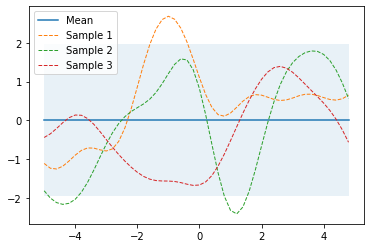

In [95]:
# Plot GP mean, confidence interval and samples 
plot_gp(mu, cov, X, samples=samples.transpose())

###### Predictive distribution for a new data point

\begin{align*}
\boldsymbol{\mu_*} &= \mathbf{K}_*^T \mathbf{K}_y^{-1} \mathbf{y} \\
\boldsymbol{\Sigma_*} &= \mathbf{K}_{**} - \mathbf{K}_*^T \mathbf{K}_y^{-1} \mathbf{K}_*
\end{align*}

In [98]:
from numpy.linalg import inv

def posterior_predictive(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    '''
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    '''
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    mu_s = K_s.T.dot(K_inv).dot(Y_train)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

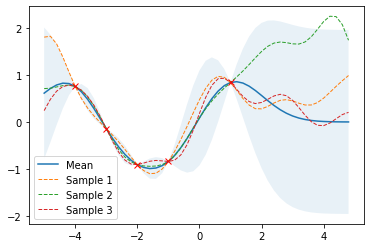

In [99]:
# Noise free training data
X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1, 1)
Y_train = np.sin(X_train)

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X, X_train, Y_train)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

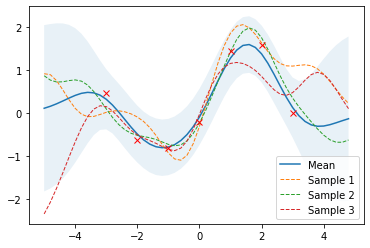

In [100]:
noise = 0.4

# Noisy training data
X_train = np.arange(-3, 4, 1).reshape(-1, 1)
Y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X, X_train, Y_train, sigma_y=noise)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)

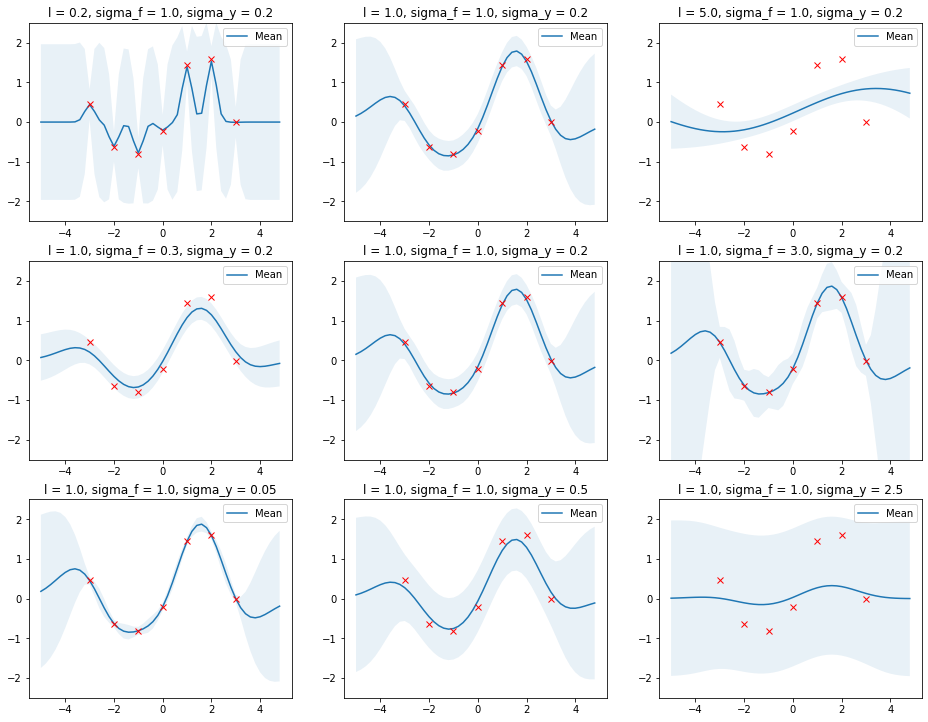

In [106]:
import matplotlib.pyplot as plt

params = [ # [length, sigma, noise]
    (0.2, 1.0, 0.2),
    (1.0, 1.0, 0.2),
    (5.0, 1.0, 0.2),
    (1.0, 0.3, 0.2),
    (1.0, 1.0, 0.2),
    (1.0, 3.0, 0.2),
    (1.0, 1.0, 0.05),
    (1.0, 1.0, 0.5),
    (1.0, 1.0, 2.5),
]

plt.figure(figsize=(16, 5))

for i, (l, sigma_f, sigma_y) in enumerate(params):
    mu_s, cov_s = posterior_predictive(X, X_train, Y_train, l=l, 
                                       sigma_f=sigma_f, 
                                       sigma_y=sigma_y)
    plt.subplot(3, 3, i + 1)
    plt.subplots_adjust(top=2)
    plt.title(f'l = {l}, sigma_f = {sigma_f}, sigma_y = {sigma_y}')
    plt.ylim(-2.5,2.5)
    plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)

###### Hyperparameter optimization 

- Find optimal length, sigma for the kernel by minimizing NLL, i.e. find hyperparameters which explains a given dataset the most.

optimal length:1.091
optimal sigma:0.894


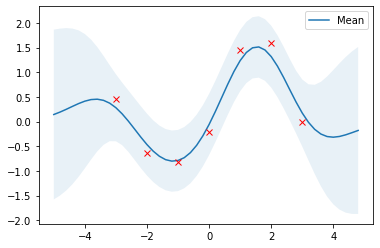

In [114]:
from numpy.linalg import cholesky
from scipy.optimize import minimize

def nll_fn(X_train, Y_train, noise):
    '''
    Returns a function that computes the negative log-likelihood
    for training data X_train and Y_train and given noise level.
    
    Args:
        X_train: training locations (m x d).
        Y_train: training targets (m x 1).
        noise: known noise level of Y_train.
        
    Returns:
        Minimization objective.
    '''
    def step(theta):
        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        # Compute determinant via Cholesky decomposition
        return np.sum(np.log(np.diagonal(cholesky(K)))) + \
               0.5 * Y_train.T.dot(inv(K).dot(Y_train)) + \
               0.5 * len(X_train) * np.log(2*np.pi)
    return step

# Minimize the negative log-likelihood w.r.t. parameters l and sigma_f.
# We should actually run the minimization several times with different
# initializations to avoid local minima but this is skipped here for
# simplicity.
res = minimize(nll_fn(X_train, Y_train, noise), [1, 1], 
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B')

# Store the optimization results in global variables so that we can
# compare it later with the results from other implementations.
l_opt, sigma_f_opt = res.x
print('optimal length:{:.3f}\noptimal sigma:{:.3f}'.format(l_opt, sigma_f_opt))

# Compute the prosterior predictive statistics with optimized kernel parameters and plot the results
mu_s, cov_s = posterior_predictive(X, X_train, Y_train, l=l_opt, sigma_f=sigma_f_opt, sigma_y=noise)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)